# Improving Neural Networks

- This is Part-3 of our image recognition study. In Part-1, we build a fully connected neural network only observed random accuracy 17%. In Part-2, we added convolutional layers and increased our accuracy to 52%. Now, **we will implement most of the techniques we discussed in "Improving Neural Networks" lecture**. In particular, **transfer learning** and **data augmentation** will be particularly important. 


- Long story short, if you get a job assignment to create an image classification model, **transfer learning MUST be your number one strategy.** 


- Most of the sections are exactly the same with FCNN and CNN notebooks, except the fact that we will directly use an already build neural network model. Instead of trying to build a model from scratch, we will employ one of the pre-trained state-of-the-art image recognition architecture "EfficientNet". Orginal paper published by Google researchers is [here](https://arxiv.org/abs/1905.11946). You can also have a look at the video [here](https://www.youtube.com/watch?v=3svIm5UC94I) for the brief summary of this paper.


<img src="data/efficientnet.png" alt="Drawing" style="width: 500px;"/>



- To be more precise, almost all of computer vision models consist of a layer called "classification(segmentation etc) head" at the end of the architecture. We first modify this head based on our model. In a classification task, we have to change the number outputs(i.e. number of classes) in bare minimum. We can add new layers as well. For example, EfficientNet has 1000 output features since it was trained on ImageNet dataset with 1000 classes. We will change to it to 6, which is our number of classes.



After that we two options:
- (1) We can **freeze** all the layers of the model and train only the sections we added. This means gradients will be propagated through the early layer. In other words, we do not change the parameters in the early layers. This road is very fast since we train only a fraction (say few thousands out of ~15M) of the parameters in the system.


- (2) After modifying the last layers, we can actually train the entire model. Although this process requires significantly more resources, it usually results in better results.



-  We will create a simple function to get "efficient-net" and try both types of training to see which one gives better result.



In [1]:
%matplotlib inline
from PIL import Image
#===========================#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import timm
import os
from torchinfo import summary
import warnings
warnings.filterwarnings('ignore') 
#===custom functions===========#
from utils import get_data_paths,view_samples,view_class_dist,seed_everything
from utils import train_test_model, load_model
from utils import display_predictions, get_confusion_matrix,plot_confusion_matrix,get_scores,display_misclassified_images,display_all_scores
from utils import get_all_feature_maps,visualize_feature_maps

#make sure to have GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

#make your code reproducible
seed_everything()

NVIDIA GeForce RTX 2070 Super
NVIDIA GeForce RTX 2070 Super


In [2]:
train_dir = "snicker_data/train/"
test_dir =  "snicker_data/test"
train_image_paths,test_image_paths = get_data_paths(train_dir, test_dir)

- This is how we embed several transformations to our model. In each epoch, we resize each image to 224x244 since EfficientNet originally was trained on this size. We then perform random horizontal and vertical flips. Randomness, 50% change if you do not specify in *p* argument in the corresponding function, is important because we do not want to alter the input for each training cycle. We convert to tensor and normalize the each image channel around the given values. Hw: where do these mean and std values come from? 


- Notice that finding which augmentation works best is a formidable task for mortals like us. However, we can take advantage of *Auto Augmentation* concept. The idea is based on a paper from Google [here](https://arxiv.org/pdf/1805.09501.pdf). "Pytorch offers pre-trained policies for popular datasets like CIFAR-10, ImageNet, and SVHN in the AutoAugment package. We will use ImageNet policies. Recall that the EfficientNet was trained on ImageNet. Thus, this approach conceptually should improve our results.


- Notice that we only have three standard transformation for testing images because we do not need to augment them. Think about it...

In [3]:
#resize the images
width = 224
height = 224

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transforms = transforms.Compose([transforms.Resize((width,height)),
                                         transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.ToTensor(),
                                         transforms.Normalize(mean,std)
                                         ])




# training_transforms = transforms.Compose([transforms.Resize((width,height)),
#                     transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
#                     transforms.ToTensor(),
#                     transforms.Normalize(mean,std)
#                 ])

test_transforms = transforms.Compose([#transforms.CenterCrop(128),
                                      transforms.Resize((width,height)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)
                                     ])




train_set = datasets.ImageFolder(train_dir, transform = training_transforms,)
test_set  = datasets.ImageFolder(test_dir, transform = test_transforms)


#this is what is loaded in each batch
batch_size = 16
train_loader = DataLoader(train_set,batch_size = batch_size,shuffle=True,num_workers=os.cpu_count(),drop_last=True)
test_loader = DataLoader(test_set,batch_size = batch_size,num_workers=os.cpu_count())

In [4]:
class_list = train_set.classes
class_to_idx = train_set.class_to_idx
print(class_to_idx)
idx_to_class = {i:j for i, j in enumerate(class_list)}
num_classes = len(class_list)
class_counts = torch.bincount(torch.tensor(train_set.targets)).tolist()

print(class_counts)

{'adidas': 0, 'converse': 1, 'new-balance': 2, 'nike': 3, 'reebok': 4, 'vans': 5}
[90, 98, 92, 95, 95, 93]


- Here is how a sample image from our batch looks like after applying the data augmentation. 
- It looks weird because of the normalization. It
may be problem for us but it is good for the model. We will talk about it in the class.

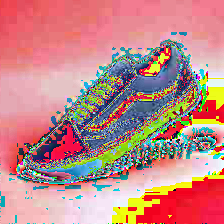

In [5]:

img,lab = next(iter(train_loader))
img = img[0]
ten2pil = transforms.ToPILImage()
img = ten2pil(img)
display(img)

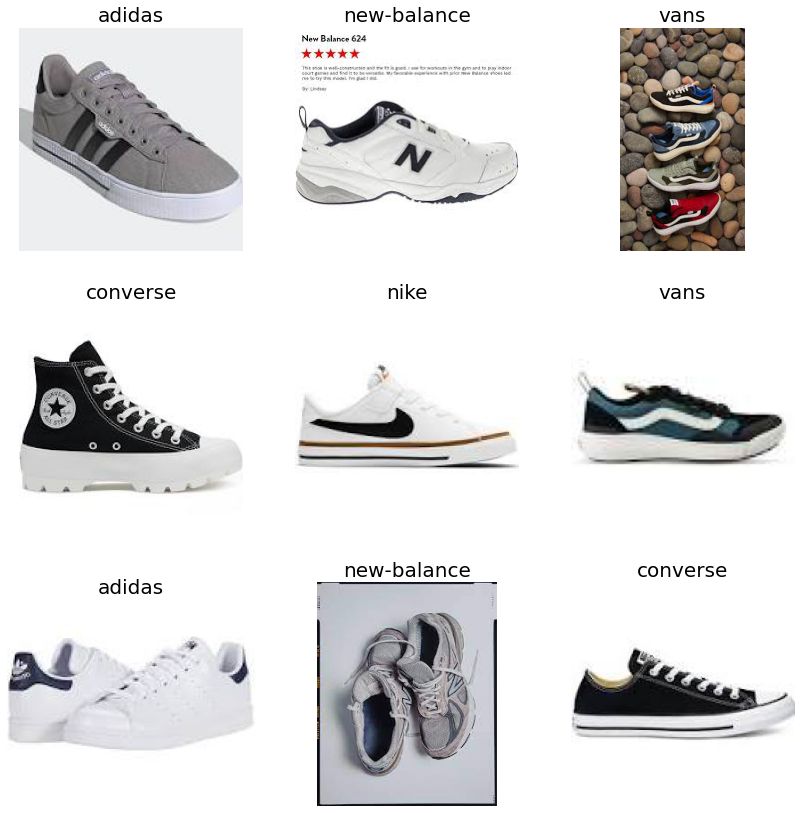

In [6]:
#view some samples in nxn grid
view_samples(n=3,img_paths=train_image_paths)

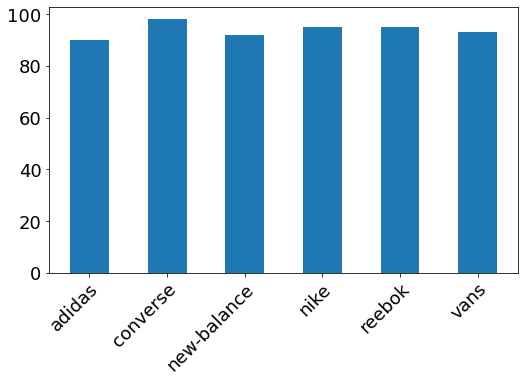

In [7]:
#check the class distribution
view_class_dist(class_list=class_list,class_counts=class_counts)

# Transfer Learning with EfficientNet

- We will get EfficientNet B0(base version) in this section from timm library. Before creating a function, let's see what we have in this model. Do not be intimidated by what you see, we will just use it as a black-box model and it will work just fine...However, we can see lots of similar items we discussed in the class, regular CNNs, batch normalization, sigmoid activation, linear layer at the end etc.

In [8]:
model = timm.create_model(model_name = 'efficientnet_b0',pretrained=True)
# print(model)

In [9]:
model.classifier

Linear(in_features=1280, out_features=1000, bias=True)

In [10]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [1, 1000]                 --
├─Conv2d: 1-1                                 [1, 32, 112, 112]         864
├─BatchNorm2d: 1-2                            [1, 32, 112, 112]         64
├─SiLU: 1-3                                   [1, 32, 112, 112]         --
├─Sequential: 1-4                             [1, 320, 7, 7]            --
│    └─Sequential: 2-1                        [1, 16, 112, 112]         --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 16, 112, 112]         1,448
│    └─Sequential: 2-2                        [1, 24, 56, 56]           --
│    │    └─InvertedResidual: 3-2             [1, 24, 56, 56]           6,004
│    │    └─InvertedResidual: 3-3             [1, 24, 56, 56]           10,710
│    └─Sequential: 2-3                        [1, 40, 28, 28]           --
│    │    └─InvertedResidual: 3-4             [1, 40, 28, 28]           15,350
│    

Let's understand the outcome little bit more;
- Look at the classifier head, we have 1000 output neurons. It is because EfficientNet was trained on ImageNet with 1000 classes. We have to change modify this portion and change the output to 6 in our case. Torchinfo output tells us we have 5,288,548 trainable parameters. It is because we have not "frozen" any layer yet.


- B0 is the base EfficientNet model For the full-model list(b0,b1,b2 etc), check [timm repo](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/efficientnet.py). Full list of models can be displayed with "timm.list_models()".


- We can now define the following function. Notice that if freeze=true then requires_grad attribute of model paramaters is set to False. So they will not be trained. We add replace classifier head with one connected layer with 100 neurons and also output layer with 5 neurons. Inspect the torchinfo output again... Out of 4,136,153 parameters only 128,605 is trainable.

- Here are all versions of efficientnet, we can use in our GetModel function. Higher the model versions usually have more parameters, meaning that more training time. For example, "efficientnetv2_l" has around 117M parameters...

In [11]:
def GetModel(model_name = 'efficientnet_b0',freeze = True):
    model = timm.create_model(model_name = model_name,pretrained=True)
    if freeze:
        for parameter in model.parameters():
            parameter.requires_grad = False
    
    in_features = model.classifier.in_features # 1792
    
    model.classifier = nn.Sequential(
                          nn.Linear(in_features, 100), 
                          nn.BatchNorm1d(num_features=100),
                          nn.ReLU(),
                          nn.Dropout(),
                          nn.Linear(100, num_classes),
                                    )
    
    return model

In [12]:
#check number of trainable parameters
model  = GetModel(model_name='efficientnet_b0',freeze=True)
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [1, 6]                    --
├─Conv2d: 1-1                                 [1, 32, 112, 112]         (864)
├─BatchNorm2d: 1-2                            [1, 32, 112, 112]         (64)
├─SiLU: 1-3                                   [1, 32, 112, 112]         --
├─Sequential: 1-4                             [1, 320, 7, 7]            --
│    └─Sequential: 2-1                        [1, 16, 112, 112]         --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 16, 112, 112]         (1,448)
│    └─Sequential: 2-2                        [1, 24, 56, 56]           --
│    │    └─InvertedResidual: 3-2             [1, 24, 56, 56]           (6,004)
│    │    └─InvertedResidual: 3-3             [1, 24, 56, 56]           (10,710)
│    └─Sequential: 2-3                        [1, 40, 28, 28]           --
│    │    └─InvertedResidual: 3-4             [1, 40, 28, 28]           (1

# Training and Testing


In [13]:
# model = GetModel(freeze=False)
# num_epochs = 60
# lr = 1e-4
# log_int = 5
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# train_test_model(model, train_loader, test_loader, optimizer, num_epochs,log_int)

In [14]:
##83.9
# model = GetModel(freeze=False)
# num_epochs = 60
# lr = 1e-4
# log_int = 5
# optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)
# train_test_model(model, train_loader, test_loader, optimizer, num_epochs,log_int)

In [15]:
##85.31--> apply policy
# model = GetModel(freeze=False)
# num_epochs = 60
# lr = 1e-4
# log_int = 5
# optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)
# train_test_model(model, train_loader, test_loader, optimizer, num_epochs,log_int)


# Evaluate the Model Performance

First let's load the saved model and use it to evaluate our model performance

In [16]:
#this will reload the model with 'learned parameters'
model  = GetModel(freeze=False)
model = load_model(model,"best_model.pth")
model.best_scores

{'BestTestAcc': 0.8591549295774648, 'lr': 0.0001}

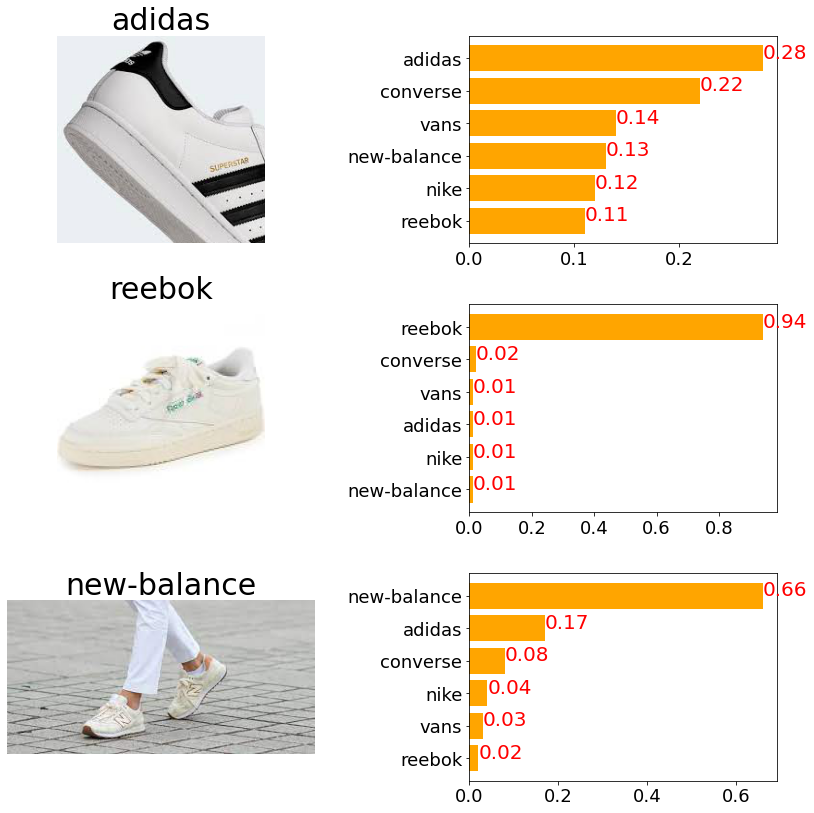

In [17]:
display_predictions(model=model,img_paths=test_image_paths,n=3,topk=num_classes,
                test_transforms=test_transforms,idx_to_class=idx_to_class)

- Notice that top2 accuracy is 90%. This means 90% of the time, our prediction is either true or it is second prediction.

top2_accuracy: 90.14%


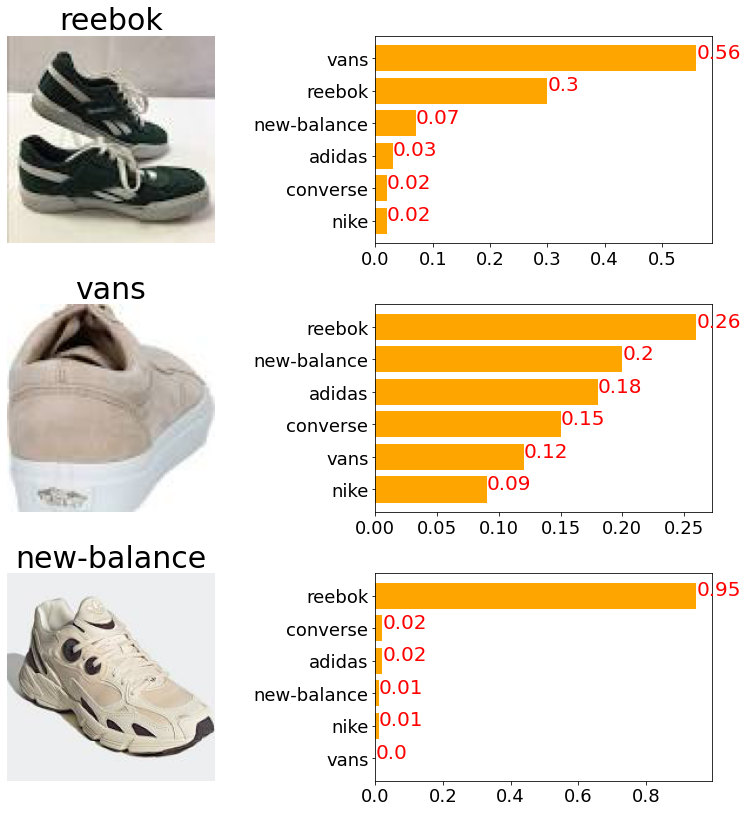

In [18]:
display_misclassified_images(model=model,test_image_paths=test_image_paths,
                           n=3,topk=num_classes,test_transforms=test_transforms,idx_to_class=idx_to_class)

## Confusion Matrix

- The most important outcome of a classification problem is the confusion matrix. Each **row** of the matrix represents the instances **actual class** while each **column** represents the instances in a **predicted class**. 
-  Confusion matrix allows us to determine all the necessary metrics to evaluate the performance of an image classification model. First of all, let's see how we interpret confusion matrix for a simple scenario.
- Notice that comparing the previous model in Part-1, the metrics are way better.

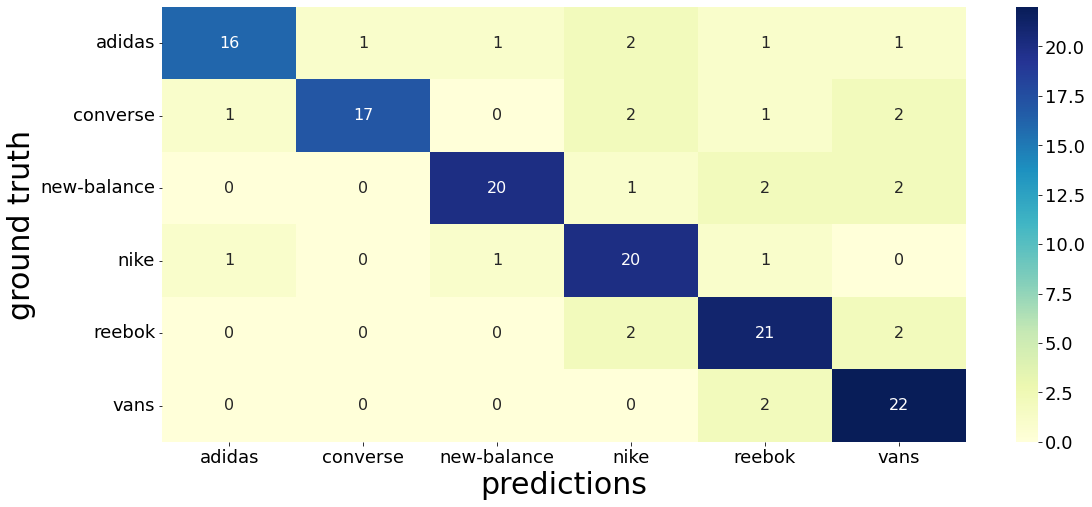

In [19]:
cm = get_confusion_matrix(model,test_loader)
plot_confusion_matrix(cm,class_list)

## Recall, Precision and F1 Score

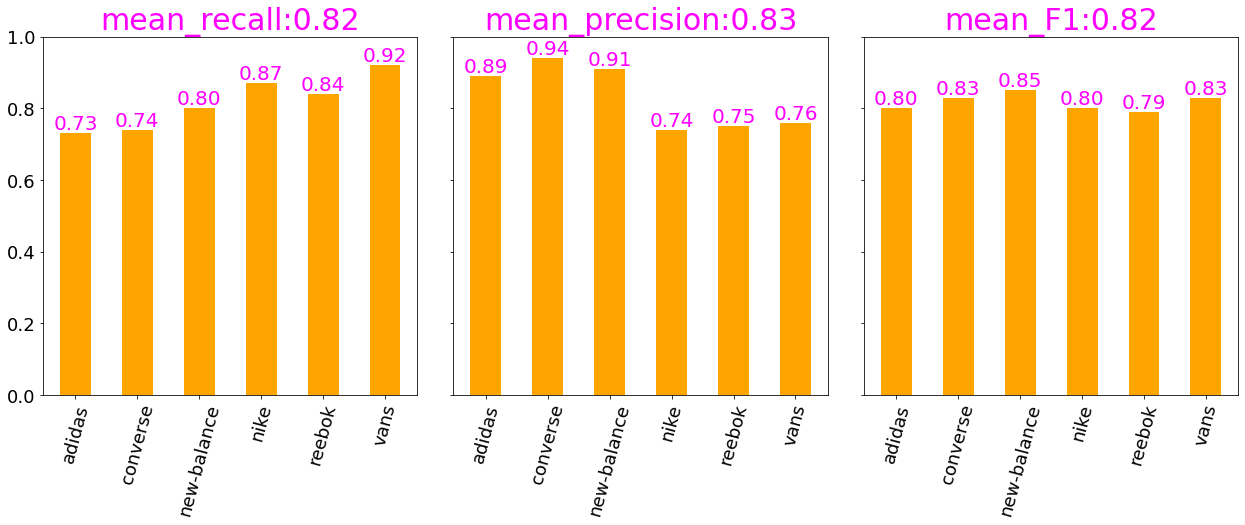

In [20]:
display_all_scores(cm,class_list)

# Visualize the Filters and Feature Maps

- This section is a great demonstration why CNNs are key components of image understanding problems. Remember we apply kernels to different channels to obtain feature maps. What we display below are feature maps associated with different layers after the application of the corresponding kernels.


- **Notice that each kernel reveals a different feature about the original image. As the input image flows through the model, the model learns very different aspect of it just like we learn.**


- Notice that we have way more **meaningful** patterns comparing to our 54% accurate CNN model in the previous notebook.


In [27]:
image_path = test_image_paths[12]
vis_dict,selected_layers = get_all_feature_maps(model,image_path,test_transforms)

34/81 convolutional layers is selected
pick one of these layer numbers to visualize dict_keys([0, 1, 4, 5, 6, 9, 10, 11, 14, 15, 16, 19, 20, 21, 24, 25, 26, 29, 30, 31, 34, 35, 36, 39, 40, 41, 44, 45, 46, 49, 50, 51, 54, 55])


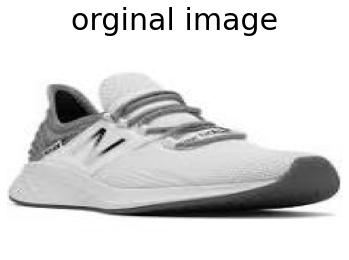

feature map size: 112x112


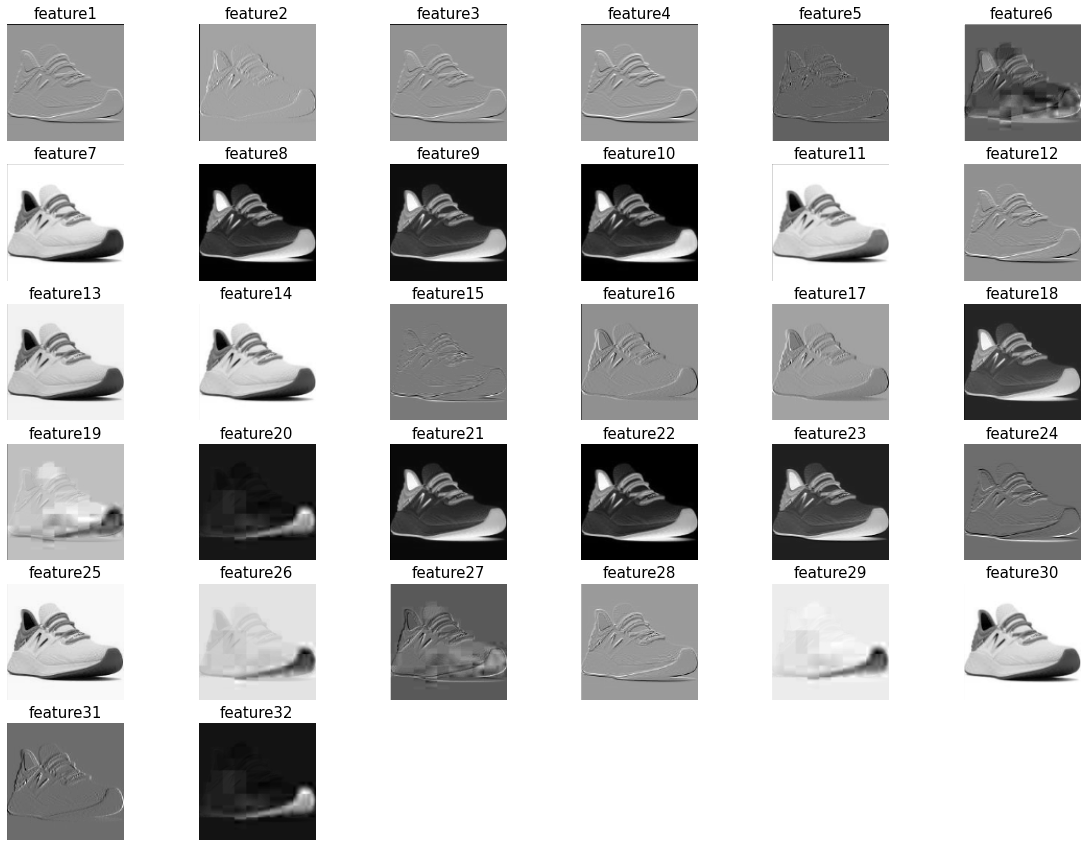

In [28]:
visualize_feature_maps(vis_dict,image_path,layer_num=0)

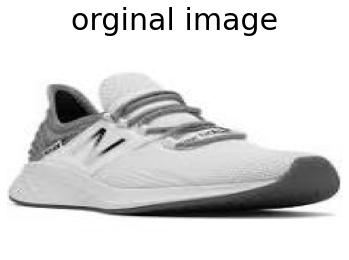

feature map size: 112x112


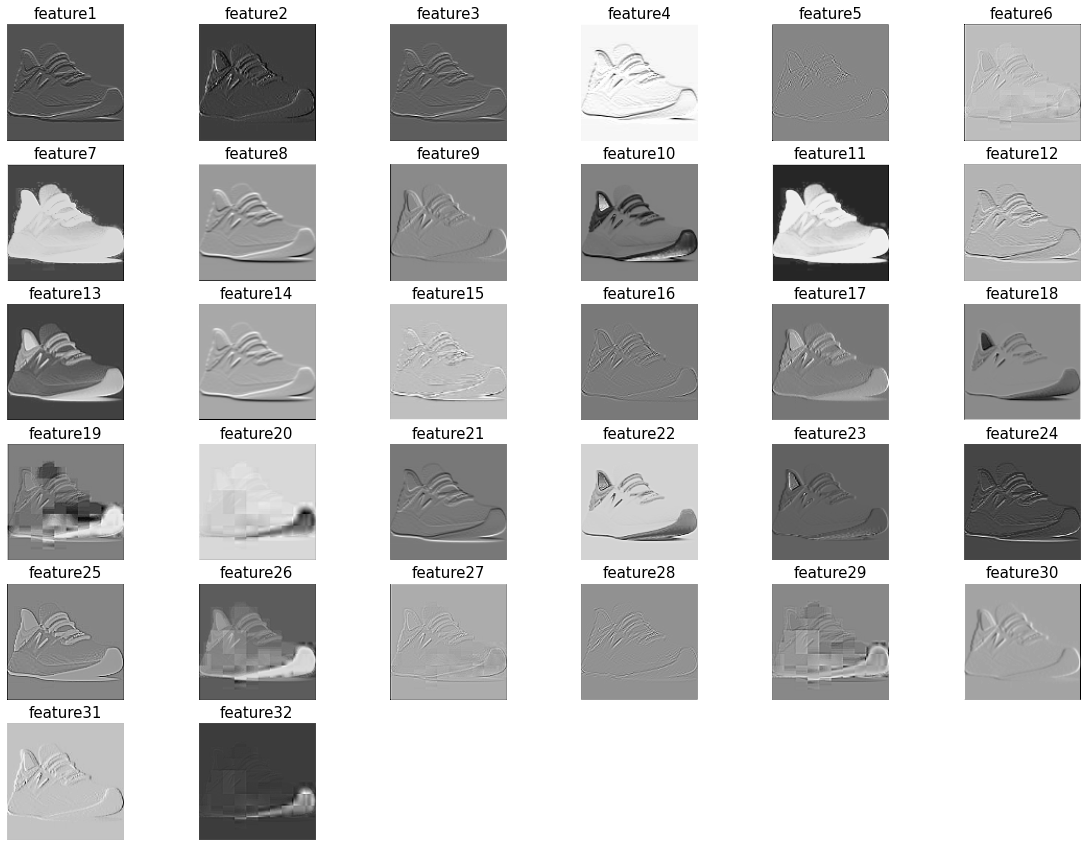

In [29]:
visualize_feature_maps(vis_dict,image_path,layer_num=1)